In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


In [19]:
import pandas as pd
import numpy as np
import optuna
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
import keras.backend as k
from keras.models import Model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Activation, Dropout, Add, Input, LayerNormalization, Flatten, Permute, Multiply
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras import callbacks
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = (y_true.index)+1

    return df_train, df_test, y_true

In [4]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

<ipython-input-3-176712a87040>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
<ipython-input-3-176712a87040>:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
<ipython-input-3-176712a87040>:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])


((20631, 20), (13096, 19), (100, 2))

### Data Preprocessing

In [5]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train.head(5)

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL
0,1,1,-0.080460,-0.666667,-1.0,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.600784,-0.272028,-0.333333,0.426357,0.449323,191
1,1,2,0.218391,-0.500000,-1.0,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.674373,-0.177376,-0.333333,0.333333,0.462027,190
2,1,3,-0.494253,0.500000,-1.0,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.656414,-0.285110,-0.666667,0.255814,0.242751,189
3,1,4,0.080460,0.000000,-1.0,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.650222,-0.666795,-0.333333,0.147287,0.324772,188
4,1,5,-0.218391,-0.333333,-1.0,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.650532,-0.195845,-0.166667,0.178295,0.409003,187


In [7]:
df_test.head(5)

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,-1.0,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.735680,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-1.0,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.590463,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-1.0,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.688719,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-1.0,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.659820,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-1.0,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.694499,-0.398230,-0.666667,0.317829,0.432753


In [8]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

In [9]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [10]:
def gen_test(id_df, seq_length, seq_cols):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)

    id_df = pd.concat([df_mask, id_df], ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    start = num_elements-seq_length
    stop = num_elements

    lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

In [11]:
sequence_length = 30

In [12]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(17731, 30, 17)


In [13]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(17731,)

In [14]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 30, 17)


In [15]:
#true target of test
y_test = y_true.RUL.values
y_test.shape

(100,)

In [16]:
rul_max = 125
corrected_y_train = np.where(y_train > rul_max, rul_max, y_train)
corrected_y_test = np.where(y_test > rul_max, rul_max, y_test)
print(corrected_y_test)

[112  98  69  82  91  93  91  95 111  96  97 124  95 107  83  84  50  28
  87  16  57 111 113  20 125 119  66  97  90 115   8  48 106   7  11  19
  21  50 125  28  18  10  59 109 114  47 125  92  21  79 114  29  26  97
 125  15 103  37 114 100  21  54  72  28 125  14  77   8 121  94 118  50
 125 125 113  10  34 107  63  90   8   9 125  58 118  89 116 115 125  28
  38  20  85  55 125 125  82  59 117  20]


In [17]:
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train, corrected_y_train, test_size=0.2, random_state=42
)

In [ ]:
nb_features = x_train.shape[2]
nb_out = 1

In [ ]:
nb_features

17

In [20]:
def objective(trial):

    units1 = trial.suggest_int('units1', 64, 128)
    units2 = trial.suggest_int('units2', 64, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    l2_lambda = trial.suggest_float('l2_lambda', 1e-4, 1e-2, log=True)

    inputs = Input(shape=(30, 17))

    x = LSTM(units=units1, return_sequences=True, kernel_regularizer=l2(l2_lambda))(inputs)
    x = LayerNormalization()(x)

    x = LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda))(x)
    x = LayerNormalization()(x)

    x = Permute((2, 1))(x)
    importance = Dense(1, activation='sigmoid')(x)
    attention_probs = Dense(x.shape[-1], activation='softmax')(importance)
    attention_score = Multiply()([x, attention_probs])
    attention_score = Permute((2, 1))(attention_score)

    x = Flatten()(attention_score)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(units=1, activation='relu')(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)
    history = model.fit(x_train_split, y_train_split, epochs=32, batch_size=64,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                                                   patience=15, verbose=1, mode='auto',
                                                                   restore_best_weights=True), reduce_lr])

    val_rmse = history.history['val_root_mean_squared_error'][-1]

    return val_rmse


In [21]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=12)

print('Best trial:', study.best_trial.params)

[I 2024-12-20 05:02:01,499] A new study created in memory with name: no-name-05abce12-e5e8-4c06-a646-0c0d5152e1da


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 8080.3271 - root_mean_squared_error: 89.8840 - val_loss: 7809.8359 - val_root_mean_squared_error: 88.3674 - learning_rate: 7.6258e-05
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 7899.6353 - root_mean_squared_error: 88.8733 - val_loss: 7523.2690 - val_root_mean_squared_error: 86.7308 - learning_rate: 7.6258e-05
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7665.7603 - root_mean_squared_error: 87.5446 - val_loss: 7227.5767 - val_root_mean_squared_error: 85.0090 - learning_rate: 7.6258e-05
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7278.7505 - root_mean_squared_error: 85.3064 - val_loss: 6920.3857 - val_root_mean_squared_error: 83.1826 - learning_rate: 7.6258e-05
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6955.4521 - root_mean_squared_error: 83.3924 - val_loss: 6601.9512 - val_root_mean_squared_error: 81.2460 - learning_rate: 7.6258e-05
Epoch 6/32
222/222 ━━━━━

[I 2024-12-20 05:03:46,120] Trial 0 finished with value: 20.766664505004883 and parameters: {'units1': 110, 'units2': 89, 'dropout_rate': 0.12802639436624463, 'learning_rate': 7.625779483756448e-05, 'l2_lambda': 0.005195695360836435}. Best is trial 0 with value: 20.766664505004883.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 4879.5586 - root_mean_squared_error: 68.6789 - val_loss: 325.5718 - val_root_mean_squared_error: 18.0391 - learning_rate: 0.0038
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 311.0810 - root_mean_squared_error: 17.6257 - val_loss: 275.7531 - val_root_mean_squared_error: 16.5995 - learning_rate: 0.0038
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 211.4664 - root_mean_squared_error: 14.5250 - val_loss: 176.0590 - val_root_mean_squared_error: 13.2597 - learning_rate: 0.0038
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 173.1072 - root_mean_squared_error: 13.1459 - val_loss: 161.4258 - val_root_mean_squared_error: 12.6945 - learning_rate: 0.0038
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 164.2762 - root_mean_squared_error: 12.8047 - val_loss: 159.5028 - val_root_mean_squared_error: 12.6166 - learning_rate: 0.0038
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step -

[I 2024-12-20 05:05:23,772] Trial 1 finished with value: 1.822403907775879 and parameters: {'units1': 96, 'units2': 94, 'dropout_rate': 0.32884065087556613, 'learning_rate': 0.00379338308552184, 'l2_lambda': 0.00037473120838532815}. Best is trial 1 with value: 1.822403907775879.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 7577.2334 - root_mean_squared_error: 87.0205 - val_loss: 5357.1865 - val_root_mean_squared_error: 73.1921 - learning_rate: 5.1580e-04
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4725.0039 - root_mean_squared_error: 68.6616 - val_loss: 2587.6123 - val_root_mean_squared_error: 50.8675 - learning_rate: 5.1580e-04
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2162.7754 - root_mean_squared_error: 46.3917 - val_loss: 947.5728 - val_root_mean_squared_error: 30.7807 - learning_rate: 5.1580e-04
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 762.6436 - root_mean_squared_error: 27.5629 - val_loss: 364.8013 - val_root_mean_squared_error: 19.0964 - learning_rate: 5.1580e-04
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 323.0915 - root_mean_squared_error: 17.9622 - val_loss: 249.8191 - val_root_mean_squared_error: 15.8015 - learning_rate: 5.1580e-04
Epoch 6/32
222/222 ━━━━━━━━━━━

[I 2024-12-20 05:07:10,312] Trial 2 finished with value: 6.202625751495361 and parameters: {'units1': 97, 'units2': 125, 'dropout_rate': 0.23404840260909426, 'learning_rate': 0.000515804317339794, 'l2_lambda': 0.0005146075061841394}. Best is trial 1 with value: 1.822403907775879.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 7752.4517 - root_mean_squared_error: 88.0211 - val_loss: 5812.1616 - val_root_mean_squared_error: 76.2332 - learning_rate: 6.0951e-04
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5240.0562 - root_mean_squared_error: 72.3275 - val_loss: 3093.6206 - val_root_mean_squared_error: 55.6140 - learning_rate: 6.0951e-04
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2568.8372 - root_mean_squared_error: 50.6099 - val_loss: 1226.9821 - val_root_mean_squared_error: 35.0173 - learning_rate: 6.0951e-04
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1011.5204 - root_mean_squared_error: 31.7107 - val_loss: 469.0174 - val_root_mean_squared_error: 21.6382 - learning_rate: 6.0951e-04
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 421.5033 - root_mean_squared_error: 20.4928 - val_loss: 274.0499 - val_root_mean_squared_error: 16.5293 - learning_rate: 6.0951e-04
Epoch 6/32
222/222 ━━━━━━━━━

[I 2024-12-20 05:08:41,663] Trial 3 finished with value: 6.433772563934326 and parameters: {'units1': 128, 'units2': 82, 'dropout_rate': 0.20296164124789112, 'learning_rate': 0.0006095122096387652, 'l2_lambda': 0.003058381128043364}. Best is trial 1 with value: 1.822403907775879.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 8290.2314 - root_mean_squared_error: 91.0485 - val_loss: 7981.0825 - val_root_mean_squared_error: 89.3368 - learning_rate: 2.7203e-05
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8147.8262 - root_mean_squared_error: 90.2641 - val_loss: 7859.6597 - val_root_mean_squared_error: 88.6546 - learning_rate: 2.7203e-05
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7990.4058 - root_mean_squared_error: 89.3885 - val_loss: 7741.3042 - val_root_mean_squared_error: 87.9846 - learning_rate: 2.7203e-05
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7773.4761 - root_mean_squared_error: 88.1657 - val_loss: 7622.6060 - val_root_mean_squared_error: 87.3074 - learning_rate: 2.7203e-05
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7737.0225 - root_mean_squared_error: 87.9596 - val_loss: 7503.2090 - val_root_mean_squared_error: 86.6209 - learning_rate: 2.7203e-05
Epoch 6/32
222/222 ━━━━━━

[I 2024-12-20 05:10:15,275] Trial 4 finished with value: 64.03202056884766 and parameters: {'units1': 95, 'units2': 107, 'dropout_rate': 0.10967312837706324, 'learning_rate': 2.720277921790761e-05, 'l2_lambda': 0.00011913512151414738}. Best is trial 1 with value: 1.822403907775879.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 4475.0439 - root_mean_squared_error: 65.4817 - val_loss: 336.3439 - val_root_mean_squared_error: 18.2579 - learning_rate: 0.0053
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 268.6890 - root_mean_squared_error: 16.2838 - val_loss: 218.9067 - val_root_mean_squared_error: 14.6802 - learning_rate: 0.0053
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 196.2289 - root_mean_squared_error: 13.8818 - val_loss: 208.4771 - val_root_mean_squared_error: 14.3088 - learning_rate: 0.0053
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 179.8539 - root_mean_squared_error: 13.2590 - val_loss: 165.4358 - val_root_mean_squared_error: 12.7061 - learning_rate: 0.0053
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 167.1940 - root_mean_squared_error: 12.7688 - val_loss: 181.9099 - val_root_mean_squared_error: 13.3219 - learning_rate: 0.0053
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step -

[I 2024-12-20 05:11:50,107] Trial 5 finished with value: 2.1146299839019775 and parameters: {'units1': 107, 'units2': 77, 'dropout_rate': 0.10860289119090331, 'learning_rate': 0.005258756925987556, 'l2_lambda': 0.006274351537834504}. Best is trial 1 with value: 1.822403907775879.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 8214.6797 - root_mean_squared_error: 90.6290 - val_loss: 7888.5034 - val_root_mean_squared_error: 88.8145 - learning_rate: 5.8494e-05
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 8035.0220 - root_mean_squared_error: 89.6311 - val_loss: 7683.1475 - val_root_mean_squared_error: 87.6508 - learning_rate: 5.8494e-05
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7633.4385 - root_mean_squared_error: 87.3646 - val_loss: 7471.1392 - val_root_mean_squared_error: 86.4330 - learning_rate: 5.8494e-05
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7552.6841 - root_mean_squared_error: 86.9012 - val_loss: 7252.7422 - val_root_mean_squared_error: 85.1602 - learning_rate: 5.8494e-05
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7275.1465 - root_mean_squared_error: 85.2858 - val_loss: 7028.0078 - val_root_mean_squared_error: 83.8304 - learning_rate: 5.8494e-05
Epoch 6/32
222/222 ━━━━━━

[I 2024-12-20 05:13:23,754] Trial 6 finished with value: 36.531005859375 and parameters: {'units1': 80, 'units2': 84, 'dropout_rate': 0.39345729673247665, 'learning_rate': 5.8494244633560716e-05, 'l2_lambda': 0.0029985686236213183}. Best is trial 1 with value: 1.822403907775879.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 5912.0210 - root_mean_squared_error: 76.3369 - val_loss: 470.5729 - val_root_mean_squared_error: 21.6918 - learning_rate: 0.0021
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 345.6619 - root_mean_squared_error: 18.5575 - val_loss: 216.2107 - val_root_mean_squared_error: 14.7024 - learning_rate: 0.0021
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 212.5632 - root_mean_squared_error: 14.5757 - val_loss: 170.7769 - val_root_mean_squared_error: 13.0661 - learning_rate: 0.0021
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 175.8921 - root_mean_squared_error: 13.2587 - val_loss: 193.2309 - val_root_mean_squared_error: 13.8985 - learning_rate: 0.0021
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 170.1620 - root_mean_squared_error: 13.0349 - val_loss: 146.5752 - val_root_mean_squared_error: 12.1040 - learning_rate: 0.0021
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step -

[I 2024-12-20 05:15:06,545] Trial 7 finished with value: 7.802167892456055 and parameters: {'units1': 101, 'units2': 111, 'dropout_rate': 0.3348295297903001, 'learning_rate': 0.0020936051477478766, 'l2_lambda': 0.00013418134248402544}. Best is trial 1 with value: 1.822403907775879.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 7898.2471 - root_mean_squared_error: 88.8320 - val_loss: 6299.9595 - val_root_mean_squared_error: 79.3610 - learning_rate: 3.5533e-04
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5918.4521 - root_mean_squared_error: 76.8927 - val_loss: 4262.3472 - val_root_mean_squared_error: 65.2732 - learning_rate: 3.5533e-04
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3857.4038 - root_mean_squared_error: 62.0521 - val_loss: 2457.7163 - val_root_mean_squared_error: 49.5572 - learning_rate: 3.5533e-04
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2175.5623 - root_mean_squared_error: 46.5627 - val_loss: 1229.2059 - val_root_mean_squared_error: 35.0336 - learning_rate: 3.5533e-04
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1071.9016 - root_mean_squared_error: 32.6677 - val_loss: 625.1389 - val_root_mean_squared_error: 24.9647 - learning_rate: 3.5533e-04
Epoch 6/32
222/222 ━━━━━━━

[I 2024-12-20 05:16:38,702] Trial 8 finished with value: 6.920862197875977 and parameters: {'units1': 119, 'units2': 123, 'dropout_rate': 0.1717720262741773, 'learning_rate': 0.00035533417051831443, 'l2_lambda': 0.008346140881041854}. Best is trial 1 with value: 1.822403907775879.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 8285.6484 - root_mean_squared_error: 91.0146 - val_loss: 7949.0068 - val_root_mean_squared_error: 89.1492 - learning_rate: 2.7945e-05
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 8069.5166 - root_mean_squared_error: 89.8219 - val_loss: 7810.9531 - val_root_mean_squared_error: 88.3716 - learning_rate: 2.7945e-05
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7880.0190 - root_mean_squared_error: 88.7606 - val_loss: 7680.2964 - val_root_mean_squared_error: 87.6292 - learning_rate: 2.7945e-05
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 7849.8394 - root_mean_squared_error: 88.5871 - val_loss: 7550.4375 - val_root_mean_squared_error: 86.8851 - learning_rate: 2.7945e-05
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7651.5044 - root_mean_squared_error: 87.4640 - val_loss: 7420.4858 - val_root_mean_squared_error: 86.1341 - learning_rate: 2.7945e-05
Epoch 6/32
222/222 ━━━━━━

[I 2024-12-20 05:18:20,353] Trial 9 finished with value: 61.047794342041016 and parameters: {'units1': 100, 'units2': 116, 'dropout_rate': 0.24001163455880217, 'learning_rate': 2.7944698088204117e-05, 'l2_lambda': 0.007177852892140354}. Best is trial 1 with value: 1.822403907775879.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 3321.0762 - root_mean_squared_error: 55.3660 - val_loss: 264.7335 - val_root_mean_squared_error: 16.2611 - learning_rate: 0.0087
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 242.0305 - root_mean_squared_error: 15.5436 - val_loss: 297.2402 - val_root_mean_squared_error: 17.2290 - learning_rate: 0.0087
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 198.3687 - root_mean_squared_error: 14.0619 - val_loss: 181.6934 - val_root_mean_squared_error: 13.4621 - learning_rate: 0.0087
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 174.1690 - root_mean_squared_error: 13.1744 - val_loss: 182.2457 - val_root_mean_squared_error: 13.4795 - learning_rate: 0.0087
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 154.6714 - root_mean_squared_error: 12.4107 - val_loss: 183.7666 - val_root_mean_squared_error: 13.5311 - learning_rate: 0.0087
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step -

[I 2024-12-20 05:19:49,409] Trial 10 finished with value: 2.658078193664551 and parameters: {'units1': 64, 'units2': 97, 'dropout_rate': 0.30868966228227046, 'learning_rate': 0.008709406900989638, 'l2_lambda': 0.00048746092027428044}. Best is trial 1 with value: 1.822403907775879.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 3367.5667 - root_mean_squared_error: 56.1171 - val_loss: 221.0568 - val_root_mean_squared_error: 14.8310 - learning_rate: 0.0097
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 218.1531 - root_mean_squared_error: 14.7278 - val_loss: 201.9480 - val_root_mean_squared_error: 14.1623 - learning_rate: 0.0097
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 198.4527 - root_mean_squared_error: 14.0343 - val_loss: 182.5299 - val_root_mean_squared_error: 13.4513 - learning_rate: 0.0097
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 176.5955 - root_mean_squared_error: 13.2260 - val_loss: 171.0605 - val_root_mean_squared_error: 13.0102 - learning_rate: 0.0097
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 160.7048 - root_mean_squared_error: 12.6026 - val_loss: 160.3369 - val_root_mean_squared_error: 12.5805 - learning_rate: 0.0097
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step -

[I 2024-12-20 05:21:23,786] Trial 11 finished with value: 2.4836833477020264 and parameters: {'units1': 85, 'units2': 72, 'dropout_rate': 0.3099081742341884, 'learning_rate': 0.009689114653747659, 'l2_lambda': 0.0013395266779384922}. Best is trial 1 with value: 1.822403907775879.


Best trial: {'units1': 96, 'units2': 94, 'dropout_rate': 0.32884065087556613, 'learning_rate': 0.00379338308552184, 'l2_lambda': 0.00037473120838532815}


In [22]:
best_params = study.best_trial.params
print(best_params)

inputs = Input(shape=(30, 17))

x = LSTM(units=best_params['units1'], return_sequences=True, kernel_regularizer=l2(best_params['l2_lambda']))(inputs)
x = LayerNormalization()(x)

x = LSTM(units=best_params['units2'], return_sequences=True, kernel_regularizer=l2(best_params['l2_lambda']))(x)
x = LayerNormalization()(x)

x = Permute((2, 1))(x)
importance = Dense(1, activation='sigmoid')(x)
attention_probs = Dense(x.shape[-1], activation='softmax')(importance)
attention_mul = Multiply()([x, attention_probs])
attention_mul = Permute((2,1))(attention_mul)

x = Flatten()(attention_mul)
x = Dropout(best_params['dropout_rate'])(x)

outputs = Dense(units=1, activation='relu')(x)

model = Model(inputs, outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

{'units1': 96, 'units2': 94, 'dropout_rate': 0.32884065087556613, 'learning_rate': 0.00379338308552184, 'l2_lambda': 0.00037473120838532815}


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 30, 17)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_24 (LSTM)            │ (None, 30, 96)         │         43,776 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_24    │ (None, 30, 96)         │            192 │ lstm_24[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_25 (LSTM)            │ (None, 30, 94)         │         71,816 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_25    │ (None, 30, 94)         │            188 │ lstm_25[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_24 (Permute)      │ (None, 94, 30)         │              0 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 94, 1)          │             31 │ permute_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 94, 30)         │             60 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_12 (Multiply)    │ (None, 94, 30)         │              0 │ permute_24[0][0],      │
│                           │                        │                │ dense_37[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_25 (Permute)      │ (None, 30, 94)         │              0 │ multiply_12[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_12 (Flatten)      │ (None, 2820)           │              0 │ permute_25[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 2820)           │              0 │ flatten_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 1)              │          2,821 │ dropout_12[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 118,884 (464.39 KB)

 Trainable params: 118,884 (464.39 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
%%time
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

history1 = model.fit(x_train_split, y_train_split, epochs=64, batch_size=64,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[early_stop, reduce_lr])

Epoch 1/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 4907.4585 - root_mean_squared_error: 68.8057 - val_loss: 278.2049 - val_root_mean_squared_error: 16.6749 - learning_rate: 0.0038
Epoch 2/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 240.5447 - root_mean_squared_error: 15.5025 - val_loss: 197.7961 - val_root_mean_squared_error: 14.0571 - learning_rate: 0.0038
Epoch 3/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 201.0071 - root_mean_squared_error: 14.1697 - val_loss: 184.0800 - val_root_mean_squared_error: 13.5593 - learning_rate: 0.0038
Epoch 4/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 184.4015 - root_mean_squared_error: 13.5684 - val_loss: 163.3365 - val_root_mean_squared_error: 12.7702 - learning_rate: 0.0038
Epoch 5/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 169.7561 - root_mean_squared_error: 13.0174 - val_loss: 166.9341 - val_root_mean_squared_error: 12.9090 - learning_rate: 0.0038
Epoch 6/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step -

In [24]:
result_train = model.evaluate(x_train, corrected_y_train, verbose=1, batch_size=200)

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1070 - root_mean_squared_error: 0.8243


In [25]:
result_test = model.evaluate(x_test, corrected_y_test, verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 308.6850 - root_mean_squared_error: 17.5258


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


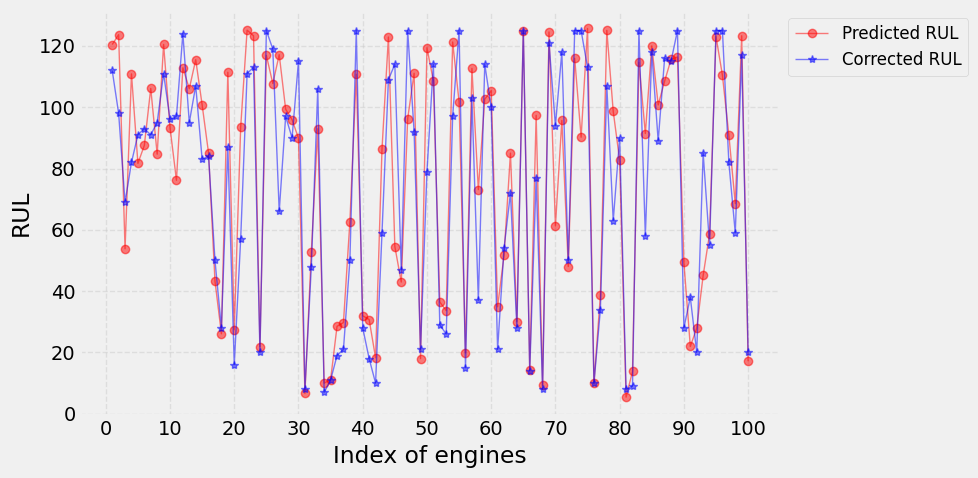

In [26]:
y_test_pred = model.predict(x_test)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(y_test_pred) + 1), y_test_pred, 'ro-', label='Predicted RUL', linewidth=1, alpha=0.5)
plt.plot(range(1, len(corrected_y_test) + 1), corrected_y_test, 'b*-', label='Corrected RUL', linewidth=1, alpha=0.5)
plt.ylabel("RUL")
plt.xlabel("Index of engines")
plt.xticks(ticks=np.arange(0, 101, 10))
plt.grid(True, which='both', linestyle='--', linewidth=1, alpha=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.tight_layout()
plt.show()